In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

## Table of Content

1. Data Preprocessing
2. Age Group (Metric 1&2)
3. Channel (Metric 1&2)
4. Market (Metric 1&2)
5. Platform (Metric 1&2)
6. Finding out the Root Cause of the Issues



### 1. Data Preprocessing

In [2]:
funnel = pd.read_csv('n26_funnel_steps.csv', parse_dates = ['timestamp']) # changing datatype of timestamp into datetime
funnel

,user_id,funnel_step,timestamp
0,b64caac4-c6a8-4b85-b504-2bbd3e28e175,sign_up_initiated,2019-01-05 23:00:00
1,77d7332a-3220-49e2-bd86-780a421926ac,sign_up_initiated,2019-01-27 02:00:00
2,24fcc884-8938-49f1-ae3b-3d33ed3a9c53,sign_up_initiated,2019-01-30 02:00:00
3,55b9ab0e-72b8-4751-8225-623014cb877f,sign_up_initiated,2019-01-28 14:00:00
4,11f32569-a4b1-4850-a90a-e535e6242168,sign_up_initiated,2019-01-02 04:00:00
...,...,...,...
52407,51ea344a-6d4e-45fd-8ddd-4c245748272b,first_deposit,2019-02-13 11:00:00
52408,043cdc30-3664-4a1d-8698-ba62953e30ed,first_deposit,2019-02-04 16:00:00
52409,87ab9864-c8da-4264-9cc6-af70f9c1c550,first_deposit,2019-02-18 11:00:00
52410,4be6ddf2-ebd5-4cf8-9b30-115d9ebdf933,first_deposit,2019-01-26 18:00:00


In [3]:
# checking for the number of unique users

funnel.user_id.nunique()

21315

In [4]:
# checking for duplicated rows

funnel.duplicated().sum()

0

In [5]:
# checking for null values

funnel.isna().sum()

user_id        0
funnel_step    0
timestamp      0
dtype: int64

In [6]:
user = pd.read_csv('n26_users.csv')
user

,user_id,channel,market,platform,age
0,b64caac4-c6a8-4b85-b504-2bbd3e28e175,organic,FRA,ios,35
1,77d7332a-3220-49e2-bd86-780a421926ac,organic,FRA,ios,20
2,24fcc884-8938-49f1-ae3b-3d33ed3a9c53,paid_social,FRA,ios,25
3,55b9ab0e-72b8-4751-8225-623014cb877f,affiliate,FRA,ios,24
4,11f32569-a4b1-4850-a90a-e535e6242168,organic,FRA,ios,23
...,...,...,...,...,...
21224,79196f5f-53a5-4c71-a4f7-56ecfea173c7,paid_social,ESP,android,31
21225,4cb69f6f-0960-479e-839b-3071b945813a,organic,ESP,ios,19
21226,782d139b-3f48-429b-87d9-84910e5f3baf,affiliate,ESP,android,45
21227,c376d4dd-bcee-4ae3-9ca5-1bab74b911fc,organic,ESP,ios,25


In [7]:
# checking for the number of unique users

user.user_id.nunique()

21229

In [8]:
# checking for duplicated rows

user.duplicated().sum()

0

In [9]:
df = pd.merge(left = user, right = funnel, on = 'user_id', how = 'inner') 
# only remaining users who have records both in funnel and user

df.user_id.nunique()

21215

In [10]:
df.duplicated().sum()

0

In [11]:
# grouping ages with 4 categories

bins = [18,26,35,46,81]
labels = ['student', 'young_worker', 'exp_worker','mid_old']
df['age_group'] = pd.cut(df['age'], bins, right = False, labels = labels)

# student (18-25), young_worker (26-34), exp_worker (35-45), mid_old (46-80)

In [12]:
# extrating time & date

df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
df['weekofmonth'] = df['timestamp'].apply(week_number_of_month)
df['month_week'] = df['month'].astype(str).str.cat(df['weekofmonth'].astype(str), sep='month + week')
df['day'] =df['timestamp'].dt.day
df['month_day'] = df['month'].astype(str).str.cat(df['day'].astype(str), sep='month + day')

In [13]:
def week_eng(date_value):
    if date_value == 0:
        return "0_Mon"
    elif date_value == 1:
        return "1_Tue"
    elif date_value == 2:
        return "2_Wed"
    elif date_value == 3:
        return "3_Thu"
    elif date_value == 4:
        return "4_Fri"
    elif date_value == 5:
        return "5_Sat"
    else:
        return "6_Sun"

df['dayofweek'] = df['dayofweek'].apply(week_eng)

def feb_mar(date_value):
    if date_value == '2month + week5':
        return "3month + week1"
    else:
        return date_value
df['month_week'] = df['month_week'].apply(feb_mar)

In [14]:
bins = [0,7,12,18,22,24]
labels = ['night', 'morning', 'afternoon','evening', 'eve-night']
df['hour_group'] = pd.cut(df['hour'], bins, right = False, labels = labels)

In [15]:
# getting duration took for each step

df_time = df.groupby(['user_id']).apply(lambda x:x['timestamp'] - x['timestamp'].shift(1)).reset_index(name = 'next_time').drop(columns = 'user_id')
df_time['next_time'] = df_time['next_time']/np.timedelta64(1, 'h')
df = pd.merge(df, df_time, left_index = True, right_on = 'level_1').drop(columns = 'level_1')

In [16]:
# getting duration took to complete the whole step

df_f_time = (df.groupby(['user_id'])['timestamp'].max()-df.groupby(['user_id'])['timestamp'].min()).reset_index(name = 'final_time')
df_f_time['final_time'] = df_f_time['final_time']/np.timedelta64(1, 'h')
df = pd.merge(df, df_f_time, on = 'user_id')

In [17]:
# removing outliers 

q1 = df['final_time'].quantile(.25)
q3 = df['final_time'].quantile(.75)
iqr = q3 - q1
df = df[(df['final_time']> q1-1.5*iqr) & (df['final_time']< q3+1.5*iqr)]

# With an Interquartile Range too wide, it's hard to remove outliers properly. 

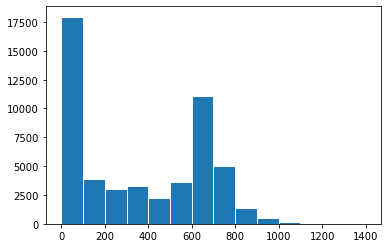

In [18]:
# checking the distribution of final_time

bins =  np.arange(df.final_time.min(), df.final_time.max()+100, 100)
plt.hist(data = df, x = 'final_time', bins = bins, edgecolor = 'white');

# Will manually delete outlier users who stayed 1000+ hours in the process, which don't seem to be normal

In [19]:
id_lists = df[df['final_time'] >=1000].user_id.values
df = df[~df['user_id'].isin(id_lists)]
df['final_time'].describe()

count    51966.000000
mean       354.432032
std        297.516838
min          0.000000
25%         29.000000
50%        330.000000
75%        642.000000
max        998.000000
Name: final_time, dtype: float64

### Metric 1. Final Conversion Rate
#### 1) Age Group

In [20]:
# aggregating the number of users, based on age group & funnel step

age = df.groupby(['funnel_step', 'age_group']).nunique('user_id')['user_id'].reset_index().sort_values(by = ['age_group', 'funnel_step'], ascending= (True, False))
age = age[['age_group', 'funnel_step', 'user_id']].reset_index()
age

,index,age_group,funnel_step,user_id
0,12,student,sign_up_initiated,7844
1,8,student,sign_up_completed,5528
2,4,student,kyc_completed,3414
3,0,student,first_deposit,2517
4,13,young_worker,sign_up_initiated,9069
5,9,young_worker,sign_up_completed,6425
6,5,young_worker,kyc_completed,3977
7,1,young_worker,first_deposit,2863
8,14,exp_worker,sign_up_initiated,1893
9,10,exp_worker,sign_up_completed,1327


In [21]:
# calculating the conversion rate to the next step

age_ratio = age.groupby(['age_group']).apply(lambda x:x['user_id']*100/x['user_id'].shift(1)).sort_index(ascending = False)\
        .reset_index(name = 'level_conversion').sort_values(by = 'level_1', ascending = True).drop(columns = ['age_group'])
age_ratio

,level_1,level_conversion
15,0,NaN
14,1,70.474248
13,2,61.758321
12,3,73.725835
11,4,NaN
10,5,70.845738
9,6,61.898833
8,7,71.988936
7,8,NaN
6,9,70.100370


In [22]:
df_age = pd.merge(age, age_ratio, left_index = True, right_on = 'level_1').reset_index().drop(columns = ['level_0','level_1', 'index'])
df_age['level_conversion'].fillna(100, inplace = True)
df_age

,age_group,funnel_step,user_id,level_conversion
0,student,sign_up_initiated,7844,100.000000
1,student,sign_up_completed,5528,70.474248
2,student,kyc_completed,3414,61.758321
3,student,first_deposit,2517,73.725835
4,young_worker,sign_up_initiated,9069,100.000000
5,young_worker,sign_up_completed,6425,70.845738
6,young_worker,kyc_completed,3977,61.898833
7,young_worker,first_deposit,2863,71.988936
8,exp_worker,sign_up_initiated,1893,100.000000
9,exp_worker,sign_up_completed,1327,70.100370


In [23]:
age_ratio = (age.groupby(['age_group']).apply(lambda x:x['user_id'])*100/age.groupby(['age_group'])['user_id'].max().sort_index(ascending = False)).reset_index(name = 'remained').drop(columns = 'age_group')
df_age = pd.merge(df_age, age_ratio, left_index = True, right_on = 'level_1').drop(columns = 'level_1')
df_age

,age_group,funnel_step,user_id,level_conversion,remained
0,student,sign_up_initiated,7844,100.000000,100.000000
1,student,sign_up_completed,5528,70.474248,70.474248
2,student,kyc_completed,3414,61.758321,43.523712
3,student,first_deposit,2517,73.725835,32.088220
4,young_worker,sign_up_initiated,9069,100.000000,100.000000
5,young_worker,sign_up_completed,6425,70.845738,70.845738
6,young_worker,kyc_completed,3977,61.898833,43.852685
7,young_worker,first_deposit,2863,71.988936,31.569081
8,exp_worker,sign_up_initiated,1893,100.000000,100.000000
9,exp_worker,sign_up_completed,1327,70.100370,70.100370


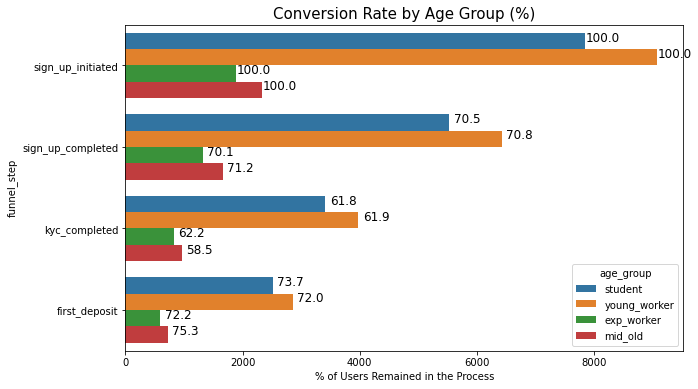

In [24]:
ax = sns.barplot(y = 'funnel_step', x = 'user_id', hue = 'age_group', data = df_age)
ax.figure.set_size_inches(10,6)
ax.set_xlabel("% of Users Remained in the Process")
ax.set_title("Conversion Rate by Age Group (%)", size = 15)

for bar, label in zip(ax.patches, round(df_age['level_conversion'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+300, y+height/2, label, ha="center", size = 12) 

In [25]:
# aggregating the number of users who went through all steps, in each age group

df_age_1 = age.groupby('age_group').agg(Max = ('user_id', 'max'), Min = ('user_id', 'min'))
df_age_1.columns = ['max', 'min']
df_age_1['final_conversion'] = round(df_age_1['min']*100 / df_age_1['max'],1)

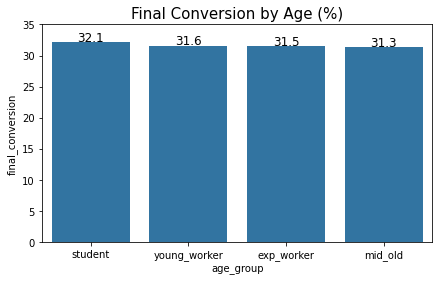

In [26]:
colors = sns.color_palette()[0]
ax = sns.barplot(x = df_age_1.index, y = 'final_conversion', data = df_age_1, color = colors)
ax.set_ylim(0,35)
ax.set_title("Final Conversion by Age (%)", size = 15)
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_age_1['final_conversion']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;

### Metric 2. Mean Duration to Complete Whole Step
#### 1) Age Group

In [27]:
df_age_next = round(df.groupby(['funnel_step','age_group'])['next_time'].mean(),1).reset_index().sort_values(by = ['age_group', 'funnel_step'], ascending= (True, False))
df_age_final = round(df.query('funnel_step == "first_deposit"').groupby('age_group')['final_time'].mean(),1).reset_index()
age_merge = pd.merge(df_age_next, df_age_final, on = 'age_group', how = 'left')
age_merge['next_time'].fillna(0, inplace = True)
age_merge

,funnel_step,age_group,next_time,final_time
0,sign_up_initiated,student,0.0,618.1
1,sign_up_completed,student,28.6,618.1
2,kyc_completed,student,225.8,618.1
3,first_deposit,student,346.1,618.1
4,sign_up_initiated,young_worker,0.0,618.8
5,sign_up_completed,young_worker,28.5,618.8
6,kyc_completed,young_worker,226.2,618.8
7,first_deposit,young_worker,345.9,618.8
8,sign_up_initiated,exp_worker,0.0,615.4
9,sign_up_completed,exp_worker,29.3,615.4


In [28]:
age_ratio = round(age_merge.groupby(['age_group']).apply(lambda x:x['next_time']*100/x['next_time'].shift(1)),1).reset_index(name = 'time_change')
age_ratio.drop(columns = ['age_group', 'level_1'], inplace = True)

age_merge = pd.merge(age_merge, age_ratio, left_index = True, right_index = True)
age_merge['time_change'].fillna(0, inplace = True)
age_merge

,funnel_step,age_group,next_time,final_time,time_change
0,sign_up_initiated,student,0.0,618.1,0.0
1,sign_up_completed,student,28.6,618.1,inf
2,kyc_completed,student,225.8,618.1,789.5
3,first_deposit,student,346.1,618.1,153.3
4,sign_up_initiated,young_worker,0.0,618.8,0.0
5,sign_up_completed,young_worker,28.5,618.8,inf
6,kyc_completed,young_worker,226.2,618.8,793.7
7,first_deposit,young_worker,345.9,618.8,152.9
8,sign_up_initiated,exp_worker,0.0,615.4,0.0
9,sign_up_completed,exp_worker,29.3,615.4,inf


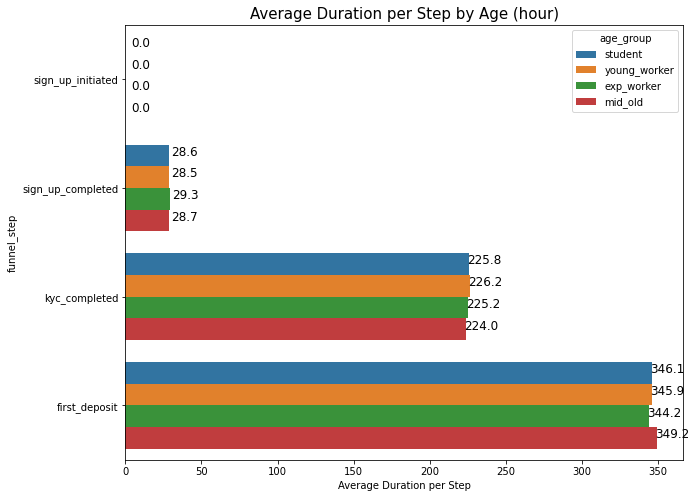

In [29]:
ax = sns.barplot(y = 'funnel_step', x = 'next_time', hue = 'age_group', data = age_merge)
ax.figure.set_size_inches(10,8)
ax.set_xlabel("Average Duration per Step")
ax.set_title("Average Duration per Step by Age (hour)", size = 15)

for bar, label in zip(ax.patches, round(age_merge['next_time'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+10, y+height/2, label, ha="center", size = 12) 

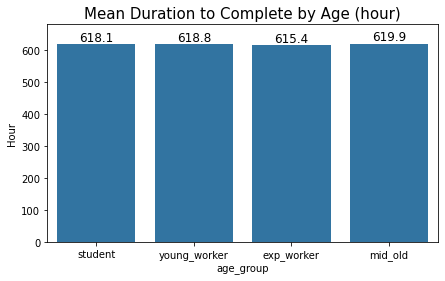

In [30]:
ax = sns.barplot(x = 'age_group', y = 'final_time', data = df_age_final, color = colors)
ax.set_title("Mean Duration to Complete by Age (hour)", size = 15)
ax.set_ylim(0,680)
ax.set_ylabel('Hour')
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_age_final['final_time']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 10, label, ha="center", size=12) ;

### Metric 1. Final Conversion Rate
#### 2) Channel

In [31]:
ch = df.groupby(['funnel_step', 'channel']).nunique('user_id')['user_id'].reset_index().sort_values(['channel', 'funnel_step'], ascending= (True,False))
ch = ch[['channel', 'funnel_step', 'user_id']].reset_index()

ch_ratio = ch.groupby(['channel']).apply(lambda x:x['user_id']*100/x['user_id'].shift(1)).sort_index(ascending = False)\
        .reset_index(name = 'level_conversion').sort_values(by = 'level_1', ascending = True).drop(columns = ['channel'])

df_ch = pd.merge(ch, ch_ratio, left_index = True, right_on = 'level_1').reset_index().drop(columns = ['level_0','level_1', 'index'])
df_ch['level_conversion'].fillna(100, inplace = True)

ch_ratio = (ch.groupby(['channel']).apply(lambda x:x['user_id'])*100/ch.groupby(['channel'])['user_id'].max().sort_index(ascending = False)).reset_index(name = 'remained').drop(columns = 'channel')
df_ch = pd.merge(df_ch, ch_ratio, left_index = True, right_on = 'level_1').drop(columns = 'level_1')

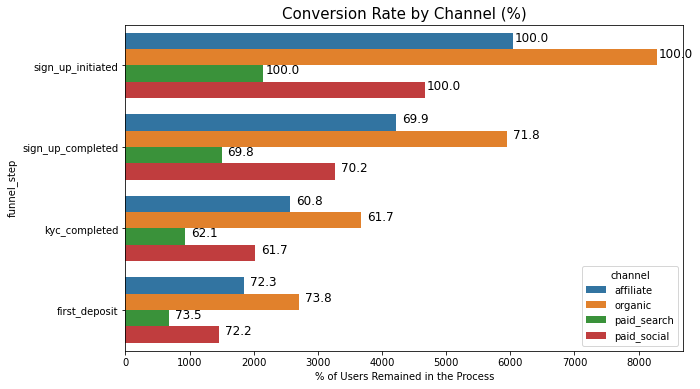

In [32]:
ax = sns.barplot(y = 'funnel_step', x = 'user_id', hue = 'channel', data = df_ch)
ax.figure.set_size_inches(10,6)
ax.set_xlabel("% of Users Remained in the Process")
ax.set_title("Conversion Rate by Channel (%)", size = 15)

for bar, label in zip(ax.patches, round(df_ch['level_conversion'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+300, y+height/2, label, ha="center", size = 12) 

In [33]:
df_ch_1 = ch.groupby('channel').agg(Max = ('user_id', 'max'), Min = ('user_id', 'min'))
df_ch_1.columns = ['max', 'min']
df_ch_1['final_conversion'] = round(df_ch_1['min']*100 / df_ch_1['max'],1)

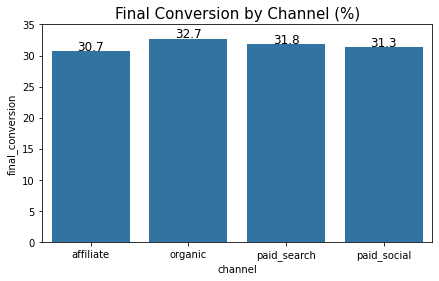

In [34]:
ax = sns.barplot(x = df_ch_1.index, y = 'final_conversion', data = df_ch_1, color = colors)
ax.set_ylim(0,35)
ax.set_title("Final Conversion by Channel (%)", size = 15)
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_ch_1['final_conversion']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;

### Metric 2. Mean Duration to Complete Whole Step
#### 2) Channel

In [35]:
df_ch_next = round(df.groupby(['funnel_step','channel'])['next_time'].mean(),1).reset_index().sort_values(by = ['channel', 'funnel_step'], ascending= (True, False))
df_ch_final = round(df.query('funnel_step == "first_deposit"').groupby('channel')['final_time'].mean(),1).reset_index()
ch_merge = pd.merge(df_ch_next, df_ch_final, on = 'channel', how = 'left')
ch_merge['next_time'].fillna(0, inplace = True)

ch_ratio = round(ch_merge.groupby(['channel']).apply(lambda x:x['next_time']*100/x['next_time'].shift(1)),1).reset_index(name = 'time_change')
ch_ratio.drop(columns = ['channel', 'level_1'], inplace = True)

ch_merge = pd.merge(ch_merge, ch_ratio, left_index = True, right_index = True)
ch_merge['time_change'].fillna(0, inplace = True)
ch_merge

,funnel_step,channel,next_time,final_time,time_change
0,sign_up_initiated,affiliate,0.0,617.7,0.0
1,sign_up_completed,affiliate,29.0,617.7,inf
2,kyc_completed,affiliate,225.1,617.7,776.2
3,first_deposit,affiliate,345.8,617.7,153.6
4,sign_up_initiated,organic,0.0,616.2,0.0
5,sign_up_completed,organic,28.4,616.2,inf
6,kyc_completed,organic,226.6,616.2,797.9
7,first_deposit,organic,343.6,616.2,151.6
8,sign_up_initiated,paid_search,0.0,620.2,0.0
9,sign_up_completed,paid_search,28.4,620.2,inf


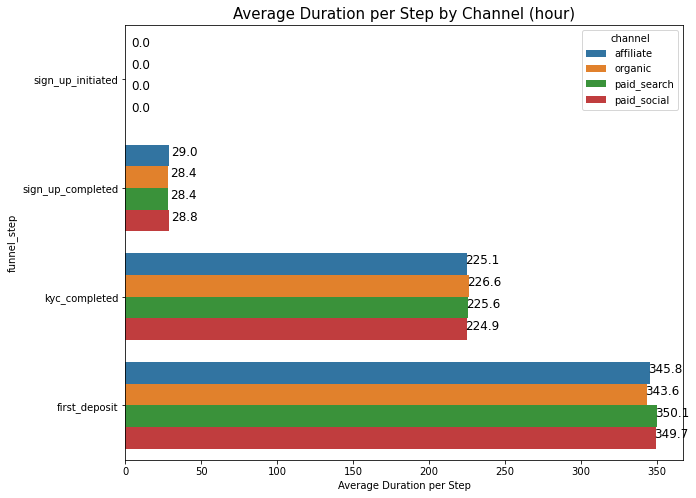

In [36]:
ax = sns.barplot(y = 'funnel_step', x = 'next_time', hue = 'channel', data = ch_merge)
ax.figure.set_size_inches(10,8)
ax.set_xlabel("Average Duration per Step")

ax.set_title("Average Duration per Step by Channel (hour)", size = 15)

for bar, label in zip(ax.patches, round(ch_merge['next_time'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+10, y+height/2, label, ha="center", size = 12) 

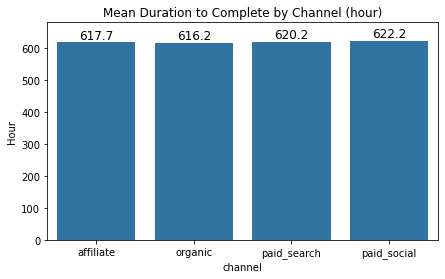

In [37]:
ax = sns.barplot(x = 'channel', y = 'final_time', data = df_ch_final, color = colors)
ax.set_title("Mean Duration to Complete by Channel (hour)")
ax.set_ylim(0,680)
ax.set_ylabel('Hour')
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_ch_final['final_time']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 10, label, ha="center", size=12) ;

### Metric 1. Final Conversion Rate
#### 3) Market

In [38]:
mkt = df.groupby(['funnel_step', 'market']).nunique('user_id')['user_id'].reset_index().sort_values(['market', 'funnel_step'], ascending= (True,False))
mkt = mkt[['market', 'funnel_step', 'user_id']].reset_index()

mkt_ratio = mkt.groupby(['market']).apply(lambda x: (x['user_id']*100/x['user_id'].shift(1))).sort_index(ascending = False)\
        .reset_index(name = 'level_conversion').sort_values(by = 'level_1', ascending = True).drop(columns = ['market'])

df_mkt = pd.merge(mkt, mkt_ratio, left_index = True, right_on = 'level_1').reset_index().drop(columns = ['level_0','level_1', 'index'])
df_mkt['level_conversion'].fillna(100, inplace = True)

mkt_ratio = (mkt.groupby(['market']).apply(lambda x:x['user_id'])*100/mkt.groupby(['market'])['user_id'].max().sort_index(ascending = False)).reset_index(name = 'remained').drop(columns = 'market')
df_mkt = pd.merge(df_mkt, mkt_ratio, left_index = True, right_on = 'level_1').drop(columns = 'level_1')

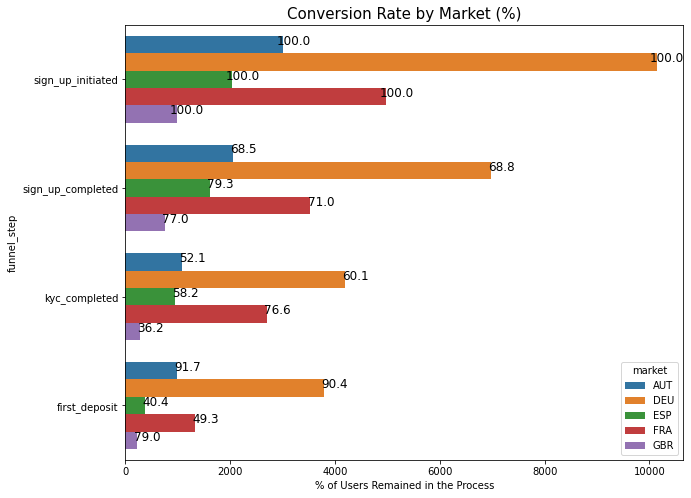

In [39]:
ax = sns.barplot(y = 'funnel_step', x = 'user_id', hue = 'market', data = df_mkt, ci= None)
ax.figure.set_size_inches(10,8)
ax.set_xlabel("% of Users Remained in the Process")
ax.set_title("Conversion Rate by Market (%)", size = 15)

for bar, label in zip(ax.patches, round(df_mkt['level_conversion'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+200, y+height/2, label, ha="center", size = 12) 

In [40]:
df_mkt_1 = mkt.groupby('market').agg(Max = ('user_id', 'max'), Min = ('user_id', 'min'))
df_mkt_1.columns = ['max', 'min']
df_mkt_1['final_conversion'] = round(df_mkt_1['min']*100/ df_mkt_1['max'],1)

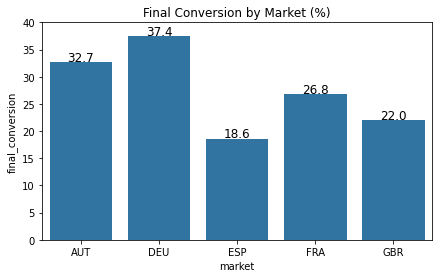

In [41]:
ax = sns.barplot(x = df_mkt_1.index, y = 'final_conversion', data = df_mkt_1, color = colors)
ax.set_ylim(0,40)
ax.set_title("Final Conversion by Market (%)")
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_mkt_1['final_conversion']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;

### Metric 2. Mean Duration to Complete Whole Step
#### 3) Market

In [42]:
df_mkt_next = round(df.groupby(['funnel_step','market'])['next_time'].mean(),1).reset_index().sort_values(by = ['market', 'funnel_step'], ascending= (True, False))
df_mkt_final = round(df.query('funnel_step == "first_deposit"').groupby('market')['final_time'].mean(),1).reset_index()
mkt_merge = pd.merge(df_mkt_next, df_mkt_final, on = 'market', how = 'left')
mkt_merge['next_time'].fillna(0, inplace = True)

mkt_ratio = round(mkt_merge.groupby(['market']).apply(lambda x:x['next_time']*100/x['next_time'].shift(1)),1).reset_index(name = 'time_change')
mkt_ratio.drop(columns = ['market', 'level_1'], inplace = True)

mkt_merge = pd.merge(mkt_merge, mkt_ratio, left_index = True, right_index = True)
mkt_merge['time_change'].fillna(0, inplace = True)
mkt_merge

,funnel_step,market,next_time,final_time,time_change
0,sign_up_initiated,AUT,0.0,757.1,0.0
1,sign_up_completed,AUT,28.9,757.1,inf
2,kyc_completed,AUT,277.8,757.1,961.2
3,first_deposit,AUT,451.2,757.1,162.4
4,sign_up_initiated,DEU,0.0,652.4,0.0
5,sign_up_completed,DEU,28.7,652.4,inf
6,kyc_completed,DEU,278.1,652.4,969.0
7,first_deposit,DEU,345.6,652.4,124.3
8,sign_up_initiated,ESP,0.0,424.5,0.0
9,sign_up_completed,ESP,28.5,424.5,inf


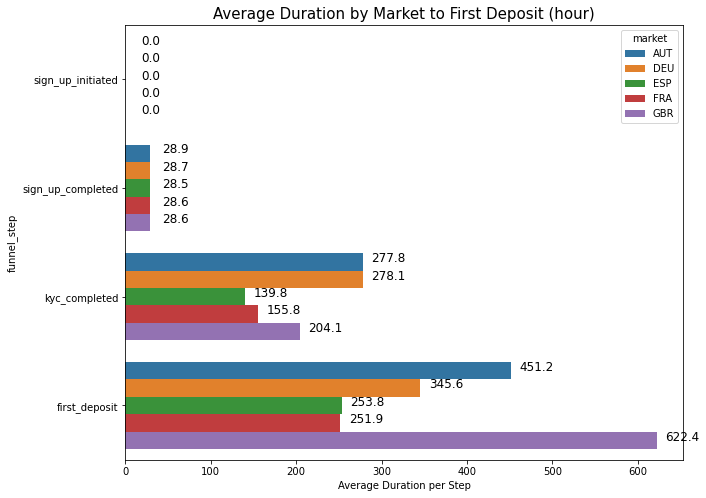

In [43]:
ax = sns.barplot(y = 'funnel_step', x = 'next_time', hue = 'market', data = mkt_merge)
ax.figure.set_size_inches(10,8)
ax.set_xlabel("Average Duration per Step")

ax.set_title("Average Duration by Market to First Deposit (hour)", size = 15)

for bar, label in zip(ax.patches, round(mkt_merge['next_time'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+30, y+height/2, label, ha="center", size = 12) 

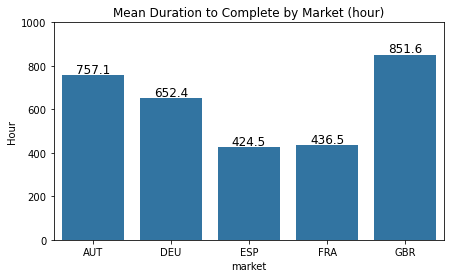

In [44]:
ax = sns.barplot(x = 'market', y = 'final_time', data = df_mkt_final, color = colors)
ax.set_title("Mean Duration to Complete by Market (hour)")
ax.set_ylim(0,1000)
ax.set_ylabel('Hour')
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_mkt_final['final_time']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 10, label, ha="center", size=12) ;

### Metric 1. Final Conversion Rate
#### 4) Platform

In [45]:
plf = df.groupby(['funnel_step', 'platform']).nunique('user_id')['user_id'].reset_index().sort_values(by = ['platform', 'funnel_step'], ascending= False)
plf = plf[['platform', 'funnel_step', 'user_id']].reset_index()

plf_ratio = plf.groupby(['platform']).apply(lambda x:x['user_id']*100/x['user_id'].shift(1)).sort_index(ascending = False)\
        .reset_index(name = 'level_conversion').sort_values(by = 'level_1', ascending = True).drop(columns = ['platform'])

df_plf = pd.merge(plf, plf_ratio, left_index = True, right_on = 'level_1').reset_index().drop(columns = ['level_0','level_1', 'index'])
df_plf['level_conversion'].fillna(100, inplace = True)

plf_ratio = (plf.groupby(['platform']).apply(lambda x:x['user_id'])*100/plf.groupby(['platform'])['user_id'].max().sort_index(ascending = False)).reset_index(name = 'remained').drop(columns = 'platform')
df_plf = pd.merge(df_plf, plf_ratio, left_index = True, right_on = 'level_1').drop(columns = 'level_1')

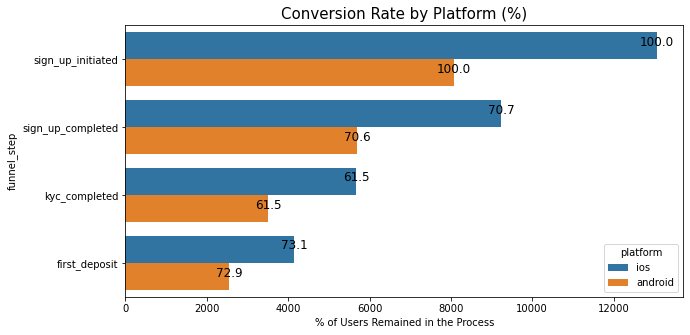

In [46]:
ax = sns.barplot(y = 'funnel_step', x = 'user_id', hue = 'platform', data = df_plf)
ax.figure.set_size_inches(10,5)
ax.set_xlabel("% of Users Remained in the Process")
ax.set_title("Conversion Rate by Platform (%)", size = 15)

for bar, label in zip(ax.patches, round(df_plf['level_conversion'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width, y+height/2, label, ha="center", size = 12) 

In [47]:
df_plf = plf.groupby('platform').agg(Max = ('user_id', 'max'), Min = ('user_id', 'min'))
df_plf.columns = ['max', 'min']
df_plf['final_conversion'] = round(df_plf['min']*100/ df_plf['max'],1)

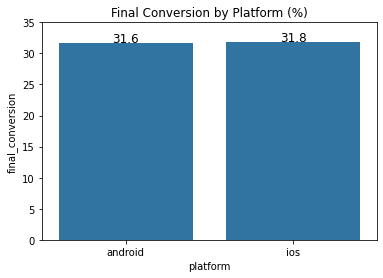

In [48]:
ax = sns.barplot(x = df_plf.index, y = 'final_conversion', data = df_plf, color = colors)
ax.set_ylim(0,35)
ax.set_title("Final Conversion by Platform (%)")
ax.figure.set_size_inches(6,4)
for bar, label in zip(ax.patches, df_plf['final_conversion']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;

### Metric 2. Mean Duration to Complete Whole Step
#### 4) Platform

In [49]:
df_plf_next = round(df.groupby(['funnel_step','platform'])['next_time'].mean(),1).reset_index().sort_values(by = ['platform', 'funnel_step'], ascending= (True, False))
df_plf_final = round(df.query('funnel_step == "first_deposit"').groupby('platform')['final_time'].mean(),1).reset_index()
plf_merge = pd.merge(df_plf_next, df_plf_final, on = 'platform', how = 'left')
plf_merge['next_time'].fillna(0, inplace = True)
plf_merge

plf_ratio = round(plf_merge.groupby(['platform']).apply(lambda x:x['next_time']*100/x['next_time'].shift(1)),1).reset_index(name = 'time_change')
plf_ratio.drop(columns = ['platform', 'level_1'], inplace = True)

plf_merge = pd.merge(plf_merge, plf_ratio, left_index = True, right_index = True)
plf_merge['time_change'].fillna(0, inplace = True)
plf_merge

,funnel_step,platform,next_time,final_time,time_change
0,sign_up_initiated,android,0.0,622.0,0.0
1,sign_up_completed,android,28.7,622.0,inf
2,kyc_completed,android,226.8,622.0,790.2
3,first_deposit,android,348.6,622.0,153.7
4,sign_up_initiated,ios,0.0,616.1,0.0
5,sign_up_completed,ios,28.6,616.1,inf
6,kyc_completed,ios,225.0,616.1,786.7
7,first_deposit,ios,344.7,616.1,153.2


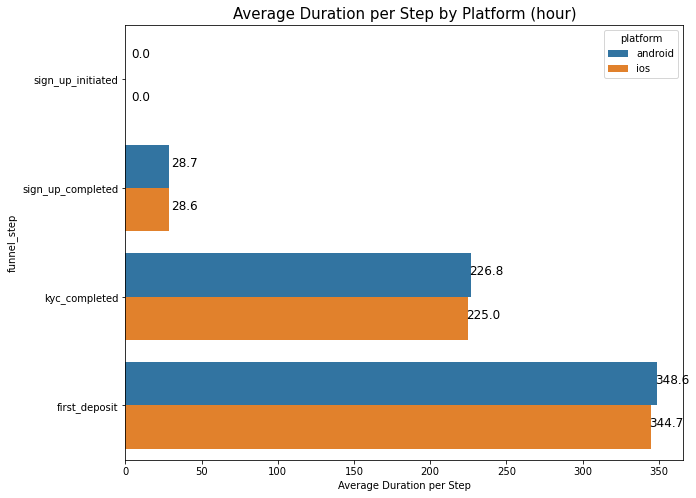

In [50]:
ax = sns.barplot(y = 'funnel_step', x = 'next_time', hue = 'platform', data = plf_merge)
ax.figure.set_size_inches(10,8)
ax.set_xlabel("Average Duration per Step")
ax.set_title("Average Duration per Step by Platform (hour)", size = 15)

for bar, label in zip(ax.patches, round(plf_merge['next_time'],1)):
    y = bar.get_y()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(width+10, y+height/2, label, ha="center", size = 12) 

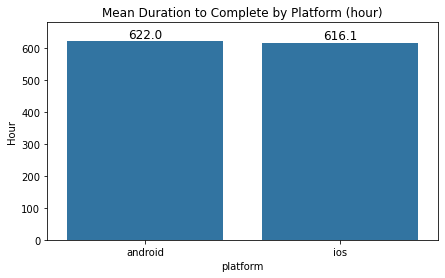

In [51]:
ax = sns.barplot(x = 'platform', y = 'final_time', data = df_plf_final, color = colors)
ax.set_title("Mean Duration to Complete by Platform (hour)")
ax.set_ylim(0,680)
ax.set_ylabel('Hour')
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, df_plf_final['final_time']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 10, label, ha="center", size=12) ;

### Finding Out the Root Cause of the Issues 


#### Issues noticed:
- Low conversion to first deposit in FRA
- Low first deposit in GBR

#### IMPORTANT ASSUMPTION: 
In real life project, I usually start with monitoring metrics in time series and checking if the issue still persists. 
However, I don't think it worth to consider time series factor (e.g. month, week...) and use it for analysis.
As FRA / ESP / GBR markets closed as below and no inflow of users, I have too small number of users in each funnel to get reliable results since February.

```Therefore I will not use time series factor - I will assume that the issue has been going on for a while.```

In [52]:
df[((df['market']=='ESP')|(df['market']=='FRA')|(df['market']=='GBR'))& (df['month']==2)].groupby(['market','month_week', 'funnel_step'])['user_id'].nunique()

market  month_week      funnel_step      
ESP     2month + week1  first_deposit         41
                        kyc_completed        121
                        sign_up_completed     93
        2month + week2  first_deposit         93
                        kyc_completed        171
        2month + week3  first_deposit         86
                        kyc_completed         12
        2month + week4  first_deposit         33
        3month + week1  first_deposit          5
FRA     2month + week1  first_deposit        122
                        kyc_completed        350
                        sign_up_completed    201
        2month + week2  first_deposit        338
                        kyc_completed        558
                        sign_up_completed      1
        2month + week3  first_deposit        336
                        kyc_completed          1
        2month + week4  first_deposit        105
        3month + week1  first_deposit         12
GBR     2month + week1  kyc

#### 1) Low conversion to first deposit in FRA

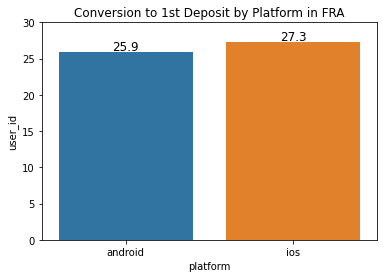

In [53]:
# step 1. hypothesis: Conversion rate might be different depending on platfrom

a = df[(df['market']=='FRA')]

gb = (a[a['funnel_step'] == 'first_deposit'].groupby(['platform', 'funnel_step'])['user_id'].nunique() *100\
 /a.groupby(['platform'])['user_id'].nunique()).reset_index()

ax= sns.barplot(data = gb, x = 'platform', y = 'user_id')
ax.set_ylim(0,30)
ax.set_title("Conversion to 1st Deposit by Platform in FRA")
for bar, label in zip(ax.patches, round(gb['user_id'],1)):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;
    
# The plot does show that the conversion rate has been a bit lower with android

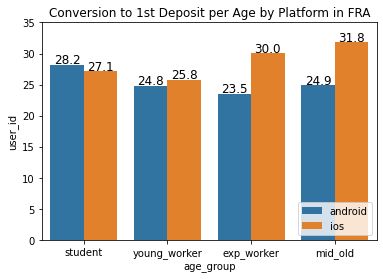

In [54]:
# step 2. hypothesis: There should be a specific age range that showed lower conversion rate with android

a = df[(df['market']=='FRA')]
gb = (a[a['funnel_step']== 'first_deposit'].groupby(['platform', 'age_group','funnel_step'])['user_id'].nunique() *100/a.groupby(['platform', 'age_group'])['user_id'].nunique()).reset_index()
ax= sns.barplot(data = gb, x = 'age_group', y = 'user_id', hue = 'platform')
ax.set_ylim(0,35)
plt.legend(loc = 'lower right')
ax.set_title("Conversion to 1st Deposit per Age by Platform in FRA")
for bar, label in zip(ax.patches, round(gb['user_id'],1)):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;
    
# The converison rate was lower in most age range. 
# I will pick exp_worker and mid_old for investigation this time, because they had significantly lower rate

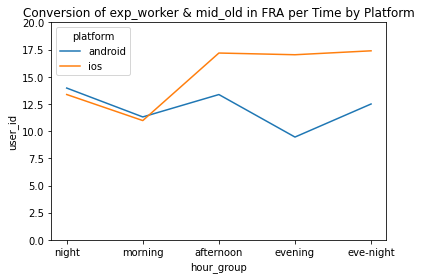

In [55]:
# step 3. hypothesis: There should be a specific timing of the day when android didn't work properly

a =  df[(df['market']== 'FRA')&((df['age_group']== 'mid_old')|(df['age_group']=='exp_worker'))]

gb = (a[(a['funnel_step']== 'first_deposit')].groupby(['market','platform','hour_group','funnel_step'])['user_id'].nunique()*100/a.groupby(['market','platform','hour_group'])['user_id'].nunique()).reset_index()
ax= sns.lineplot(data = gb, x = 'hour_group', y = 'user_id', hue = 'platform')
ax.set_ylim(0,20)
ax.set_title("Conversion of exp_worker & mid_old in FRA per Time by Platform");

# Android shows on evening & eve_night, between 18 hrs and 24 hrs. 

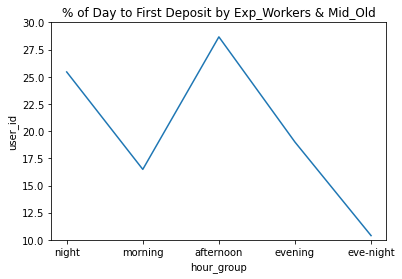

In [56]:
# Before we move to the next hypothesis, I wonder why specific timings of the day show poorer performace in terms of android.
# Let's check the frequency of first deposit timing by each age group. 

gb = (a[a['funnel_step']== 'first_deposit'].groupby(['hour_group'])['user_id'].nunique() *100 / a[a['funnel_step']== 'first_deposit'].groupby(['hour_group'])['user_id'].nunique().sum()).reset_index()
ax= sns.lineplot(data = gb, x = 'hour_group', y = 'user_id')
ax.set_title("% of Day to First Deposit by Exp_Workers & Mid_Old")
ax.set_ylim(10,30);

# More than 50% deposit attempts have been made between afternoon and eve_night (12 hrs - 24 hrs). 

# conclusion: There must have been an issue with Android in French version in deposit related feature.

#### 2) Low conversion to KYC completion in ESP 

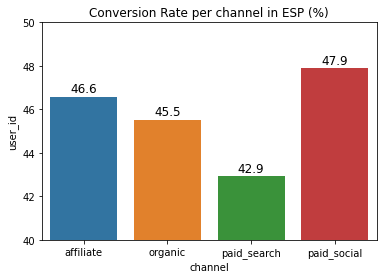

In [57]:
# step 1. hypothesis: People who started with a specific marketing channel should have a low conversion rate

a = df[df['market']=='ESP']
gb = (a[a['funnel_step']== 'kyc_completed'].groupby(['channel', 'funnel_step'])['user_id'].nunique()*100 /a.groupby(['channel'])['user_id'].nunique()).reset_index()
ax= sns.barplot(data = gb, x = 'channel', y = 'user_id')
ax.set_ylim(40,50)
ax.set_title("Conversion Rate per channel in ESP (%)")

for bar, label in zip(ax.patches, round(gb['user_id'],1)):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;
    
# By graph, paid_search has the lowest conversion rate, 
# But we can't guarantee that users with paid_search should be the cause of the low conversion, because each marketing channel has its own trend
# Need to check using KYC completion rate of all users

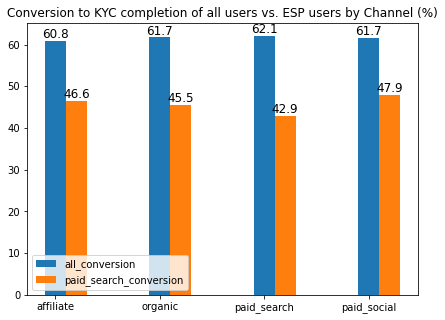

In [58]:
# step 2. Compare with KYC conversion rate of total users across the market

df_ch_new = df_ch.copy()
df_ch_new = df_ch_new[df_ch_new['funnel_step'] == 'kyc_completed'].reset_index()

gb = (a[a['funnel_step']== 'kyc_completed'].groupby(['market','channel', 'funnel_step'])['user_id'].nunique()*100 /a.groupby(['market', 'channel'])['user_id'].nunique()).reset_index()

plt.figure(figsize = (7,5))
bar = plt.bar(df_ch_new.index, df_ch_new.level_conversion, 0.2,label = 'all_conversion')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
bar2 = plt.bar(gb.index+0.2, gb.user_id, 0.2,label = 'paid_search_conversion')
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.xticks(df_ch_new.index, df_ch_new.channel)
plt.legend(loc = 'lower left')
plt.title("Conversion to KYC completion of all users vs. ESP users by Channel (%)");

# Conversion by paid_search users in ESP is still lowest, which is against the trend of conversion by all users

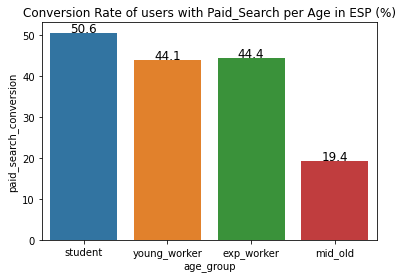

In [59]:
# step 3. hypothesis: Users with paid_search in ESP will have different conversion depending on age group

a = df[(df['market']=='ESP') & (df['channel']=='paid_search')]
gb = (a[a['funnel_step']== 'kyc_completed'].groupby(['market','channel', 'age_group','funnel_step'])['user_id'].nunique()*100 /a.groupby(['market', 'channel', 'age_group'])['user_id'].nunique()).reset_index(name = 'paid_search_conversion')

ax= sns.barplot(data = gb, x = 'age_group', y = 'paid_search_conversion')
ax.set_title("Conversion Rate of users with Paid_Search per Age in ESP (%)")

for bar, label in zip(ax.patches, round(gb['paid_search_conversion'],1)):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 0.2, label, ha="center", size=12) ;
    
# Mid_old who started the process give up on KYC much more than other age groups

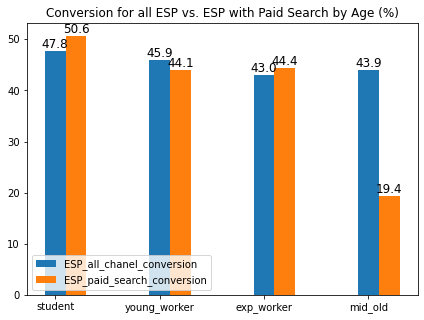

In [60]:
# Step 4. Compare with users in ESP across all channel by age

b = df[df['market']=='ESP']
gb1 = (b[b['funnel_step']== 'kyc_completed'].groupby(['market','age_group', 'funnel_step'])['user_id'].nunique()*100 /b.groupby(['market', 'age_group'])['user_id'].nunique()).reset_index(name = 'all_conversion')

plt.figure(figsize = (7,5))
bar = plt.bar(gb1.index, gb1.all_conversion, 0.2,label = 'ESP_all_chanel_conversion')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
bar2 = plt.bar(gb.index+0.2, gb.paid_search_conversion, 0.2,label = 'ESP_paid_search_conversion')
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
plt.xticks(gb1.index, gb1.age_group)
plt.legend(loc = 'lower left')
plt.title("Conversion for all ESP vs. ESP with Paid Search by Age (%)");

# conclusion: Mid_old users in ESP with paid_search seldom completed KYC, which is clearer after comparing with all ESP users

#### 3) High first deposit duration in GBR

Assumption: Users make the 1st deposit AFTER receiving a card, once they are fully equipped to use the service both with virtual & physical card

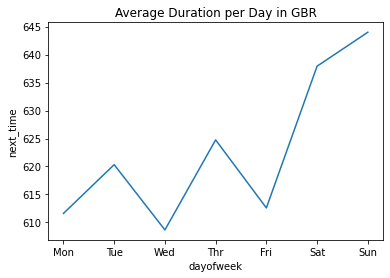

In [61]:
# step 1. hypothesis: Average duration to 1st deposit would be different depending on the week of the day 

a = df[df['market']=='GBR']
gb = (a[(a['funnel_step']=='first_deposit')].groupby(['dayofweek', 'funnel_step'])['next_time'].mean()).reset_index()

ax = sns.lineplot(data = gb, y = 'next_time', x = 'dayofweek')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])
ax.set_title("Average Duration per Day in GBR");

# Long duration on Sat&Sun means these people chose to wait until weekend, 
# Although they have received the card on weekdays already 

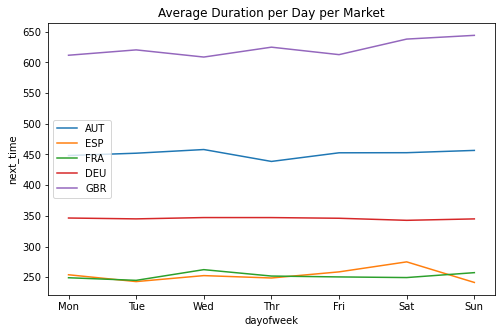

In [62]:
# Before we dig the weekend data further, I would like to briefly check if this trend is universal

plt.figure(figsize = (8,5))
gb = (df[(df['funnel_step']=='first_deposit')].groupby(['market', 'dayofweek', 'funnel_step'])['next_time'].mean()).reset_index()
ax = sns.lineplot(data = gb.sort_values(by = 'dayofweek', ascending = True), x = 'dayofweek', y = 'next_time', hue = 'market')
plt.legend(loc = 'center left')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])
plt.title("Average Duration per Day per Market");

# It seems the tendency of longer duration on weekends is only applied to GBR market

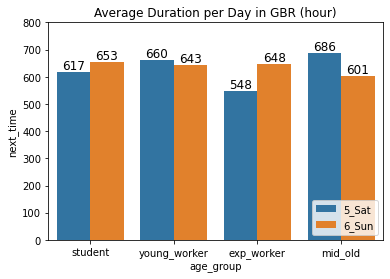

In [63]:
# step 2. hypothesis: Different age group with different lifestyle would have been the reason of  

a = df[(df['market']=='GBR') & ((df['dayofweek'] =='5_Sat')|(df['dayofweek'] =='6_Sun'))]

gb = (a[a['funnel_step']=='first_deposit'].groupby(['dayofweek','age_group','funnel_step'])['next_time'].mean()).reset_index()\
        .sort_values(by= ['dayofweek', 'age_group'], ascending = (True, True))
ax = sns.barplot(data = gb, y = 'next_time', x = 'age_group', hue = 'dayofweek')
plt.legend(loc = 'lower right')
ax.set_title("Average Duration per Day in GBR (hour)")
ax.set_ylim(0,800)

for bar, label in zip(ax.patches, gb['next_time'].astype(int)):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height + 10, label, ha="center", size=12) ;

# Young workers generally show the long duration on "both" day of weekend 
# I am going to choose the groups as the root cause of long duration

# conclusion: Young workers are too busy with their life during weekdays,and they assumed it would take long to activate a card.